In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MNIST:
    def __init__(self):
        self.session = tf.Session()

    def data(self, images, labels, batch_size=64, prefetch_buffer=128):
        with tf.variable_scope("data"):
            dataset = tf.data.Dataset.from_tensor_slices((images, labels))
            dataset = dataset.shuffle(buffer_size=20000, seed=12345).repeat()
            dataset = dataset.batch(batch_size)
            dataset = dataset.prefetch(prefetch_buffer)
            iterator = dataset.make_one_shot_iterator()
        return iterator

    def model(self, images, training, n_classes=10):
        with tf.variable_scope("model", reuse=tf.AUTO_REUSE):
            net = tf.expand_dims(images, axis=3)

            net = tf.layers.conv2d(net, 32, (5, 5), activation=tf.nn.relu)
            net = tf.layers.batch_normalization(net, training=training)
            net = tf.nn.relu(net)
            net = tf.layers.max_pooling2d(net, pool_size=(2, 2), strides=(2, 2))

            net = tf.layers.conv2d(net, 64, (5, 5))
            net = tf.layers.batch_normalization(net, training=training)
            net = tf.nn.relu(net)
            net = tf.layers.max_pooling2d(net, pool_size=(2, 2), strides=(2, 2))

            net = tf.layers.flatten(net)
            net = tf.layers.dense(net, 1024)
            net = tf.nn.relu(net)
            net = tf.layers.dropout(net, rate=0.4, training=training)
            net = tf.layers.dense(net, n_classes)

        return net

    def loss(self, logits, labels):
        with tf.variable_scope("loss"):
            return tf.losses.sparse_softmax_cross_entropy(labels, logits)

    def optimizer(self, loss):
        with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer()
            optimizer = optimizer.minimize(loss)
        return optimizer

    def optimizer_momentum(self, loss, global_step, learning_rate=0.01):
        with tf.variable_scope("optimizer", reuse=tf.AUTO_REUSE):
            lr_schedule = tf.train.exponential_decay(learning_rate=learning_rate,
                                                     global_step=global_step,
                                                     decay_steps=500,
                                                     decay_rate=0.9,
                                                     staircase=True)
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                optimizer = tf.train.MomentumOptimizer(learning_rate=lr_schedule, momentum=0.9)
                return optimizer.minimize(loss, global_step=global_step)
            
    def performance_metric(self, logits, labels):
        with tf.variable_scope("performance_metric"):
            preds = tf.argmax(logits, axis=1)
            labels = tf.cast(labels, tf.int64)
            corrects = tf.equal(preds, labels)
            accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))
        return accuracy

    def fit(self, _images, _labels, n_epochs=30, batch_size=64):
        global_step = tf.Variable(1, dtype=tf.int32, trainable=False, name="iter_number")
        images, labels = self.data(_images, _labels, batch_size).get_next()
        logits = self.model(images, True)
        loss = self.loss(logits, labels)
        optimizer = self.optimizer_momentum(loss, global_step)
        # optimizer = self.optimizer(loss)
        accuracy = self.performance_metric(logits, labels)
        self.session.run(tf.global_variables_initializer())
        _loss, _acc = 0, 0
        epoch = _images.shape[0] / batch_size
        n_iters = int((_images.shape[0] / batch_size) * n_epochs)
        history = dict(loss=[], accuracy=[], n_epochs=n_epochs)

        for i in range(1, n_iters + 1):
            _, loss_batch, acc_batch = self.session.run([optimizer, loss, accuracy])
            _loss += loss_batch
            _acc += acc_batch
            if i % epoch == 0:
                _loss /= epoch
                _acc /= epoch
                print('Epoch %2d, loss %.4f, accuracy %.2f%%' % (i / epoch, _loss, _acc * 100))
                history['loss'].append(_loss)
                history['accuracy'].append(_acc)
                _acc, _loss = 0, 0

        return history

    def eval(self, images, labels):
        logits = self.model(images, False)
        loss = self.loss(logits, labels)
        accuracy = self.performance_metric(logits, labels)

        val_loss, val_acc = self.session.run([loss, accuracy])
        print('Validation loss %.4f, accuracy %.2f%%' % (val_loss, val_acc))

    def predict(self, images):
        pred = tf.argmax(tf.nn.softmax(self.model(images, False)), axis=1)
        return pred.eval(session=self.session)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch  1, loss 0.2563, accuracy 91.76%
Epoch  2, loss 0.0737, accuracy 97.65%
Epoch  3, loss 0.0491, accuracy 98.46%
Epoch  4, loss 0.0344, accuracy 98.81%
Epoch  5, loss 0.0258, accuracy 99.19%
Epoch  6, loss 0.0178, accuracy 99.48%
Epoch  7, loss 0.0140, accuracy 99.58%
Epoch  8, loss 0.0096, accuracy 99.77%
Epoch  9, loss 0.0096, accuracy 99.76%
Epoch 10, loss 0.0074, accuracy 9

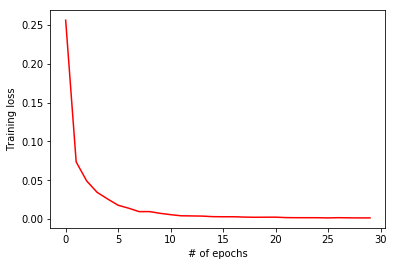

Validation loss 0.0363, accuracy 0.99%


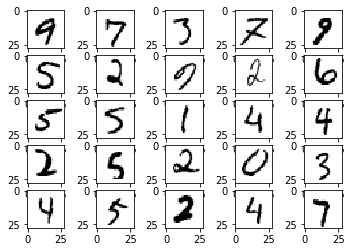

[[9 7 3 2 9]
 [5 2 9 2 6]
 [5 5 1 4 4]
 [2 5 2 0 3]
 [4 5 2 4 7]]


In [3]:
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# Prepare the data

# Rescale the data to range (0,1) for numerical stability
data_x /= 255.0
test_x /= 255.0
data_x = data_x.reshape(data_x.shape[0], 28, 28)
test_x = test_x.reshape(test_x.shape[0], 28, 28)

# Use 80/20 ratio for train and validation
train_X, train_y = data_x[:16000], data_y[:16000]
val_X, val_y = data_x[16000:], data_y[16000:]

model = MNIST()
history = model.fit(train_X, train_y)

plt.plot(np.arange(0, history['n_epochs']), history['loss'], 'r')
plt.xlabel('# of epochs')
plt.ylabel('Training loss')
plt.show()

model.eval(val_X, val_y)
prediction = model.predict(test_x)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_x[i].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

print(prediction[:25].reshape(5, 5))
assert prediction.ndim == 1
assert prediction.shape[0] == 2000
np.save('prediction.npy', prediction)